In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
mp.matplotlib_fname()

from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import sklearn.pipeline as pl
import sklearn.preprocessing as sp
import sklearn.linear_model as lm
import sklearn.metrics as sm

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.notebook_repr_html', False)
data = pd.read_excel(io='../data/附件2.xlsx', sheet_name='Sheet1')

In [3]:
# 创建单品编码与单品名称哈希表
excel1 = pd.read_excel(io='../data/附件1.xlsx', sheet_name='Sheet1')

def df2List(tabel):
    df = excel1[[tabel]]
    _array = np.array(df.stack())
    _list = _array.tolist()
    return _list

# 单品编码列表
code_list = df2List('单品编码')
# 单品名称列表
name_list = df2List('单品名称')
# 分类编码列表
class_code_list = df2List('分类编码')
# 分类名称列表
class_name_list = df2List('分类名称')

# 单品编码2单品名称哈希表
code2name = {}
for i in range(len(code_list)):
    code2name[code_list[i]] = name_list[i]
# 单品名称2分类名称哈希表
name2class = {}
for i in range(len(name_list)):
    name2class[name_list[i]] = class_name_list[i]


In [4]:
lost = pd.read_excel(io='../data/附件4.xlsx', sheet_name='Sheet1')
lost_mean = lost.copy(deep=True)
for i in range(len(lost_mean)):
    lost_mean.loc[i,'单品名称'] = name2class[lost.loc[i,'单品名称']]

lost_mean = lost_mean.groupby('单品名称', as_index=False)['损耗率(%)'].mean()
lost_mean.style

,单品名称,损耗率(%)
0,水生根茎类,11.974737
1,花叶类,10.280300
2,花菜类,14.142000
3,茄类,7.122000
4,辣椒类,8.515333
5,食用菌,8.130972


In [5]:
sell_daily = data[['销售日期', '单品编码', '销量(千克)', '销售单价(元/千克)']]
sell_daily.loc[:,'销售日期'] = pd.to_datetime(sell_daily.loc[:,'销售日期'])

for i in range(len(sell_daily)):
    sell_daily.loc[i,'单品编码'] = code2name[sell_daily.loc[i,'单品编码']]
sell_daily

             销售日期     单品编码  销量(千克)  销售单价(元/千克)
0      2020-07-01  泡泡椒(精品)   0.396         7.6
1      2020-07-01      大白菜   0.849         3.2
2      2020-07-01  泡泡椒(精品)   0.409         7.6
3      2020-07-01      上海青   0.421        10.0
4      2020-07-01       菜心   0.539         8.0
...           ...      ...     ...         ...
878498 2023-06-30  西峡花菇(1)   0.284        24.0
878499 2023-06-30      长线茄   0.669        12.0
878500 2023-06-30  西峡花菇(1)   0.125        24.0
878501 2023-06-30  芜湖青椒(1)   0.252         5.2
878502 2023-06-30      长线茄   0.803        12.0

[878503 rows x 4 columns]

In [6]:
cost = pd.read_excel(io='../data/附件3.xlsx', sheet_name='Sheet1')
for i in range(len(cost)):
    cost.loc[i,'单品编码'] = code2name[cost.loc[i,'单品编码']]
cost.rename(columns={'日期': '销售日期'}, inplace=True)
cost

            销售日期    单品编码  批发价格(元/千克)
0     2020-07-01      苋菜        3.88
1     2020-07-01    云南生菜        6.72
2     2020-07-01     竹叶菜        3.19
3     2020-07-01     小白菜        9.24
4     2020-07-01     上海青        7.03
...          ...     ...         ...
55977 2023-06-30    洪湖藕带       18.00
55978 2023-06-30     青线椒        6.45
55979 2023-06-30  黄白菜(2)        4.48
55980 2023-06-30  金针菇(盒)        1.45
55981 2023-06-30  海鲜菇(包)        1.95

[55982 rows x 3 columns]

In [7]:
price_cost_df = pd.merge(sell_daily, cost, on=['销售日期','单品编码'],how='inner')
price_cost_df = price_cost_df.groupby(['销售日期', '单品编码', '销售单价(元/千克)', '批发价格(元/千克)'], as_index=False).sum()
price_cost_df

            销售日期        单品编码  销售单价(元/千克)  批发价格(元/千克)  销量(千克)
0     2020-07-01      七彩椒(1)        16.0        7.58   1.909
1     2020-07-01         上海青        10.0        7.03  11.476
2     2020-07-01       云南油麦菜         6.0        3.44  32.579
3     2020-07-01        云南生菜         8.0        6.72  41.966
4     2020-07-01        外地茼蒿        16.0       11.69   2.623
...          ...         ...         ...         ...     ...
55726 2023-06-30  青红杭椒组合装(份)         5.8        3.32   4.000
55727 2023-06-30       高瓜(1)         8.0       11.67   2.570
55728 2023-06-30       高瓜(1)        16.0       11.67   1.210
55729 2023-06-30       高瓜(2)        10.8       13.69   0.228
55730 2023-06-30       高瓜(2)        18.0       13.69   0.284

[55731 rows x 5 columns]

In [8]:
earn_daily = pd.DataFrame()
earn_daily['销售日期'] = price_cost_df['销售日期']
earn_daily['单品编码'] = price_cost_df['单品编码']
earn_daily['利润(元)'] = price_cost_df['销量(千克)'] * (price_cost_df['销售单价(元/千克)'] - price_cost_df['批发价格(元/千克)'])
earn_daily = earn_daily.groupby(['销售日期', '单品编码'], as_index=False).sum()
earn_daily

            销售日期        单品编码     利润(元)
0     2020-07-01      七彩椒(1)  16.07378
1     2020-07-01         上海青  34.08372
2     2020-07-01       云南油麦菜  83.40224
3     2020-07-01        云南生菜  53.71648
4     2020-07-01        外地茼蒿  11.30513
...          ...         ...       ...
46594 2023-06-30      金针菇(盒)   6.35000
46595 2023-06-30         长线茄  43.94500
46596 2023-06-30  青红杭椒组合装(份)   9.92000
46597 2023-06-30       高瓜(1)  -4.19260
46598 2023-06-30       高瓜(2)   0.56512

[46599 rows x 3 columns]

### 每日利润

In [9]:
class_earn_daily = earn_daily.copy(deep=True)
for i in range(len(class_earn_daily)):
    class_earn_daily.loc[i,'单品编码'] = name2class[class_earn_daily.loc[i,'单品编码']]
class_earn_daily = class_earn_daily.groupby(['单品编码', class_earn_daily['销售日期']])['利润(元)'].sum()
class_earn_daily = class_earn_daily.unstack(0).fillna(0)
class_earn_daily

单品编码            水生根茎类        花叶类        花菜类         茄类        辣椒类        食用菌
销售日期                                                                        
2020-07-01   25.49812  512.10105  200.71800   32.08965  351.93465  138.66059
2020-07-02   20.48956  583.96795  201.69822   92.46514  292.84857  251.18003
2020-07-03   22.99408  561.73894  182.90884   53.94768  268.84345  234.01637
2020-07-04   42.52497  704.10491  244.78158  149.64214  361.91539  232.02942
2020-07-05   18.40702  616.37082  232.15808  162.74564  421.20867  301.72841
...               ...        ...        ...        ...        ...        ...
2023-06-26   51.56337  151.55983   48.98298   49.22488  195.05126   72.62880
2023-06-27   41.80670  204.40524   59.94240   26.92797  191.57681   57.28720
2023-06-28   25.37122  173.20834   71.80663   46.29587  184.84560   81.42280
2023-06-29  107.43171  195.38476   95.34600   33.90844  232.80094   72.07760
2023-06-30   46.27421  259.75396  101.21257   83.61505  196.83842   80.33480

### 每日销售额

In [10]:
value_daily = pd.DataFrame()
value_daily['销售日期'] = price_cost_df['销售日期']
value_daily['单品编码'] = price_cost_df['单品编码']
value_daily['销售额(元)'] = price_cost_df['销量(千克)'] * price_cost_df['销售单价(元/千克)']
value_daily = value_daily.groupby(['销售日期', '单品编码'], as_index=False).sum()
value_daily

            销售日期        单品编码    销售额(元)
0     2020-07-01      七彩椒(1)   30.5440
1     2020-07-01         上海青  114.7600
2     2020-07-01       云南油麦菜  195.4740
3     2020-07-01        云南生菜  335.7280
4     2020-07-01        外地茼蒿   41.9680
...          ...         ...       ...
46594 2023-06-30      金针菇(盒)   25.2000
46595 2023-06-30         长线茄  105.4680
46596 2023-06-30  青红杭椒组合装(份)   23.2000
46597 2023-06-30       高瓜(1)   39.9200
46598 2023-06-30       高瓜(2)    7.5744

[46599 rows x 3 columns]

In [11]:
class_value_daily = value_daily.copy(deep=True)
for i in range(len(class_value_daily)):
    class_value_daily.loc[i,'单品编码'] = name2class[class_value_daily.loc[i,'单品编码']]
class_value_daily = class_value_daily.groupby(['单品编码', class_value_daily['销售日期']])['销售额(元)'].sum()
class_value_daily = class_value_daily.unstack(0).fillna(0)
class_value_daily

单品编码           水生根茎类        花叶类       花菜类        茄类        辣椒类       食用菌
销售日期                                                                    
2020-07-01   70.2838  1503.7896  592.5300  176.8180   759.9902  368.6020
2020-07-02   53.1208  1409.6647  546.0320  172.0920   669.7044  605.9290
2020-07-03   76.6930  1399.5065  495.3680  196.2430   670.6646  546.2950
2020-07-04  118.7532  1841.4000  702.1860  327.4030   826.4166  578.7036
2020-07-05   40.1900  1573.1793  697.9820  411.3631  1016.2366  732.6238
...              ...        ...       ...       ...        ...       ...
2023-06-26  186.5424   430.5642  113.1620  134.9700   425.5650  216.6680
2023-06-27  263.0436   642.0896  171.2640   67.1240   422.8367  193.8920
2023-06-28  209.4314   630.4388  198.1640  121.6408   415.4488  247.9080
2023-06-29  391.5526   646.1398  292.5020   86.3524   556.4280  225.9360
2023-06-30  280.9766   667.7684  323.3425  198.8132   501.6192  258.8280

[1085 rows x 6 columns]

### 品类批发成本

In [12]:
cost_daily = pd.DataFrame()
cost_daily['销售日期'] = price_cost_df['销售日期']
cost_daily['单品编码'] = price_cost_df['单品编码']
cost_daily['批发价(元)'] = price_cost_df['销量(千克)'] * price_cost_df['批发价格(元/千克)']
cost_daily = cost_daily.groupby(['销售日期', '单品编码'], as_index=False).sum()
cost_daily

            销售日期        单品编码     批发价(元)
0     2020-07-01      七彩椒(1)   14.47022
1     2020-07-01         上海青   80.67628
2     2020-07-01       云南油麦菜  112.07176
3     2020-07-01        云南生菜  282.01152
4     2020-07-01        外地茼蒿   30.66287
...          ...         ...        ...
46594 2023-06-30      金针菇(盒)   18.85000
46595 2023-06-30         长线茄   61.52300
46596 2023-06-30  青红杭椒组合装(份)   13.28000
46597 2023-06-30       高瓜(1)   44.11260
46598 2023-06-30       高瓜(2)    7.00928

[46599 rows x 3 columns]

In [13]:
class_cost_daily = cost_daily.copy(deep=True)
for i in range(len(class_cost_daily)):
    class_cost_daily.loc[i,'单品编码'] = name2class[class_cost_daily.loc[i,'单品编码']]
class_cost_daily = class_cost_daily.groupby(['单品编码', class_cost_daily['销售日期']])['批发价(元)'].sum()
class_cost_daily = class_cost_daily.unstack(0).fillna(0)
class_cost_daily

单品编码            水生根茎类         花叶类        花菜类         茄类        辣椒类        食用菌
销售日期                                                                         
2020-07-01   44.78568   991.68855  391.81200  144.72835  408.05555  229.94141
2020-07-02   32.63124   825.69675  344.33378   79.62686  376.85583  354.74897
2020-07-03   53.69892   837.76756  312.45916  142.29532  401.82115  312.27863
2020-07-04   76.22823  1137.29509  457.40442  177.76086  464.50121  346.67418
2020-07-05   21.78298   956.80848  465.82392  248.61746  595.02793  430.89539
...               ...         ...        ...        ...        ...        ...
2023-06-26  134.97903   279.00437   64.17902   85.74512  230.51374  144.03920
2023-06-27  221.23690   437.68436  111.32160   40.19603  231.25989  136.60480
2023-06-28  184.06018   457.23046  126.35737   75.34493  230.60320  166.48520
2023-06-29  284.12089   450.75504  197.15600   52.44396  323.62706  153.85840
2023-06-30  234.70239   408.01444  222.12993  115.19815  304.780

### 每日销售量

In [14]:
class_sell_daily = sell_daily.copy(deep=True)
class_sell_daily.loc[:,'销售日期'] = pd.to_datetime(class_sell_daily.loc[:,'销售日期'])
class_sell_daily.drop('销售单价(元/千克)', axis=1)
for i in range(len(class_sell_daily)):
    class_sell_daily.loc[i,'单品编码'] = name2class[class_sell_daily.loc[i,'单品编码']]
class_sell_daily = class_sell_daily.groupby(['单品编码', class_sell_daily['销售日期']])['销量(千克)'].sum()
class_sell_daily = class_sell_daily.unstack(0).fillna(0)
class_sell_daily

单品编码         水生根茎类      花叶类     花菜类      茄类     辣椒类     食用菌
销售日期                                                       
2020-07-01   4.850  205.402  46.640  35.374  76.715  35.365
2020-07-02   4.600  198.362  43.943  32.199  66.064  48.510
2020-07-03   9.572  190.779  42.076  35.896  64.253  42.442
2020-07-04   5.439  236.587  55.662  57.067  81.282  47.262
2020-07-05   4.019  223.899  55.474  61.816  98.496  73.213
...            ...      ...     ...     ...     ...     ...
2023-06-26  10.384   80.524   8.083  21.224  72.185  39.582
2023-06-27  16.454  127.278  14.272   8.415  67.120  38.708
2023-06-28  14.946  130.182  16.069  15.651  68.534  53.742
2023-06-29  22.945  135.090  24.367  11.511  89.113  48.314
2023-06-30  19.419  130.464  28.087  24.530  82.286  39.572

[1085 rows x 6 columns]

### 每日批发价

In [15]:
class_cost_in_daily = class_cost_daily / class_sell_daily
class_cost_in_daily

单品编码            水生根茎类       花叶类       花菜类        茄类       辣椒类       食用菌
销售日期                                                                   
2020-07-01   9.234161  4.828037  8.400772  4.091376  5.319110  6.501949
2020-07-02   7.093748  4.162575  7.835919  2.472961  5.704405  7.312904
2020-07-03   5.610000  4.391299  7.426066  3.964100  6.253734  7.357774
2020-07-04  14.015119  4.807090  8.217535  3.114950  5.714687  7.335157
2020-07-05   5.420000  4.273393  8.397158  4.021895  6.041138  5.885504
...               ...       ...       ...       ...       ...       ...
2023-06-26  12.998751  3.464860  7.940000  4.040008  3.193375  3.639008
2023-06-27  13.445782  3.438806  7.800000  4.776712  3.445469  3.529110
2023-06-28  12.315013  3.512240  7.863425  4.814065  3.364800  3.097860
2023-06-29  12.382693  3.336702  8.091107  4.555986  3.631648  3.184551
2023-06-30  12.086224  3.127410  7.908639  4.696215  3.703920  4.510593

[1085 rows x 6 columns]

### 每日平均售价

In [16]:
class_value_in_daily = class_value_daily / class_sell_daily
class_value_in_daily

单品编码            水生根茎类       花叶类        花菜类        茄类        辣椒类        食用菌
销售日期                                                                      
2020-07-01  14.491505  7.321202  12.704331  4.998530   9.906670  10.422791
2020-07-02  11.548000  7.106526  12.425915  5.344638  10.137206  12.490806
2020-07-03   8.012223  7.335747  11.773172  5.466988  10.437872  12.871566
2020-07-04  21.833646  7.783183  12.615177  5.737169  10.167277  12.244586
2020-07-05  10.000000  7.026290  12.582147  6.654638  10.317542  10.006745
...               ...       ...        ...       ...        ...        ...
2023-06-26  17.964407  5.347029  14.000000  6.359310   5.895477   5.473902
2023-06-27  15.986605  5.044781  12.000000  7.976708   6.299712   5.009094
2023-06-28  14.012538  4.842749  12.332068  7.772078   6.061937   4.612928
2023-06-29  17.064833  4.783032  12.004022  7.501729   6.244072   4.676408
2023-06-30  14.469159  5.118411  11.512176  8.104900   6.096045   6.540685

[1085 rows x 6 columns]

### 成本加成比例

In [17]:
cost_addition = pd.DataFrame()
cost_addition = class_value_daily/(class_value_daily - class_earn_daily) - 1

In [18]:
cost_addition

单品编码           水生根茎类       花叶类       花菜类        茄类       辣椒类       食用菌
销售日期                                                                  
2020-07-01  0.569336  0.516393  0.512281  0.221723  0.862467  0.603026
2020-07-02  0.627912  0.707243  0.585764  1.161231  0.777084  0.708050
2020-07-03  0.428204  0.670519  0.585385  0.379125  0.669062  0.749383
2020-07-04  0.557864  0.619105  0.535154  0.841817  0.779148  0.669301
2020-07-05  0.845018  0.644195  0.498382  0.654603  0.707881  0.700236
...              ...       ...       ...       ...       ...       ...
2023-06-26  0.382010  0.543217  0.763224  0.574084  0.846159  0.504229
2023-06-27  0.188968  0.467015  0.538462  0.669916  0.828405  0.419364
2023-06-28  0.137842  0.378821  0.568282  0.614452  0.801574  0.489069
2023-06-29  0.378120  0.433461  0.483607  0.646565  0.719349  0.468467
2023-06-30  0.197161  0.636629  0.455646  0.725837  0.645836  0.450072

[1085 rows x 6 columns]

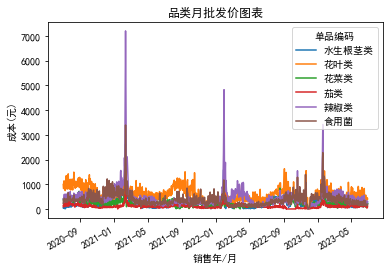

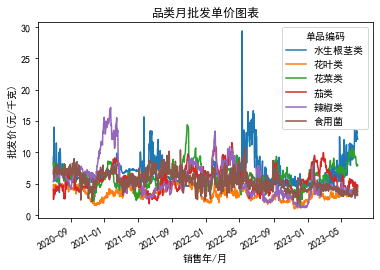

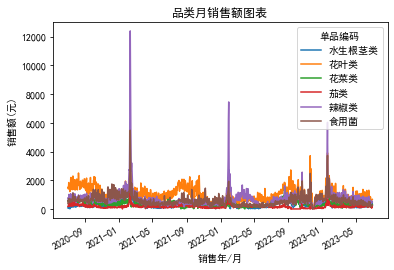

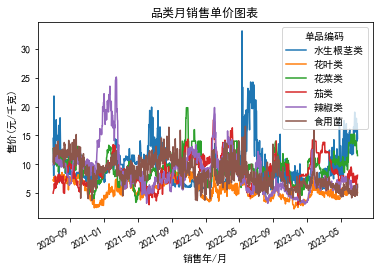

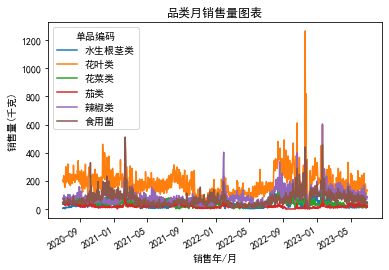

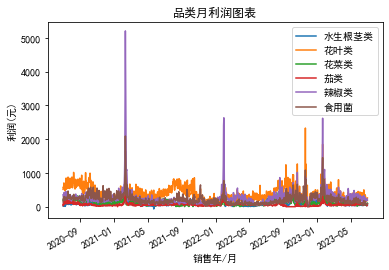

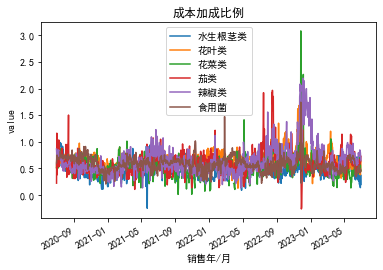

In [19]:
class_cost_daily.plot(label=class_sell_daily.index)
plt.title("品类月批发价图表")
plt.xlabel('销售年/月')
plt.ylabel('成本(元)')
class_cost_in_daily.plot(label=class_sell_daily.index)
plt.title("品类月批发单价图表")
plt.xlabel('销售年/月')
plt.ylabel('批发价(元/千克)')
class_value_daily.plot(label=class_earn_daily.index)
plt.title("品类月销售额图表")
plt.xlabel('销售年/月')
plt.ylabel('销售额(元)')
class_value_in_daily.plot(label=class_sell_daily.index)
plt.title("品类月销售单价图表")
plt.xlabel('销售年/月')
plt.ylabel('售价(元/千克)')
class_sell_daily.plot(label=class_sell_daily.index)
plt.title("品类月销售量图表")
plt.xlabel('销售年/月')
plt.ylabel('销售量(千克)')
class_earn_daily.plot(label=class_earn_daily.index)
plt.title("品类月利润图表")
plt.xlabel('销售年/月')
plt.ylabel('利润(元)')
plt.legend(loc='best')
plt.show()
cost_addition.plot(label=cost_addition.index)
plt.title("成本加成比例")
plt.xlabel('销售年/月')
plt.ylabel('value')
plt.legend(loc='best')
plt.show()

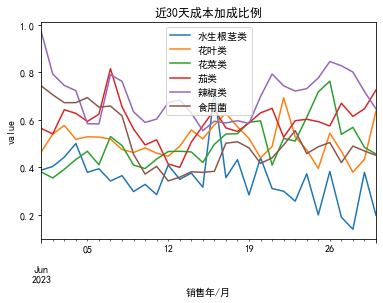

In [20]:
cost_addition[-30::].plot(label=cost_addition.index)
plt.title("近30天成本加成比例")
plt.xlabel('销售年/月')
plt.ylabel('value')
plt.legend(loc='best')
plt.show()

代价函数
$$
J(w,b)=\frac{1}{m}\sum^{m}_{i=1}|f_{\vec{w},b}(\vec{x}^{(i)})-y^{(i)}|
$$

In [21]:
def CostFunc(y, pred_y):
    J = 0
    for i in range(len(y)):
        J += abs(pred_y[i] - y[i])
    J = J / len(y)
    return J

### 基于ARIMA模型

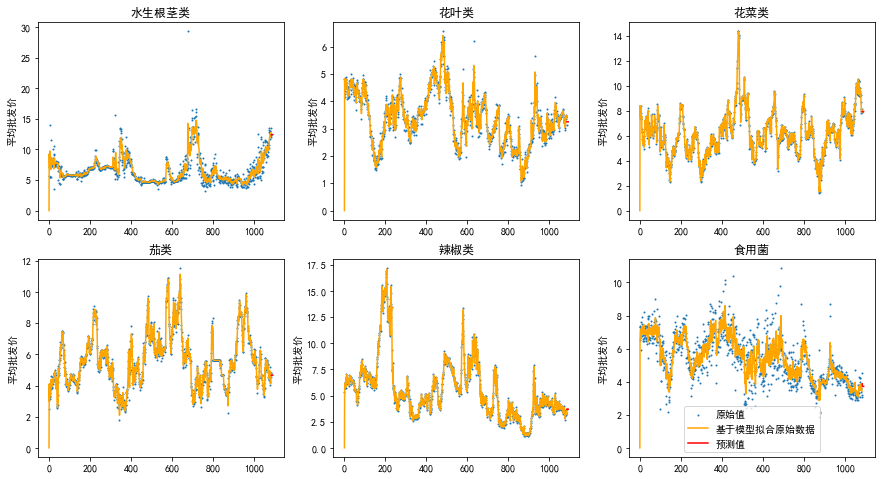

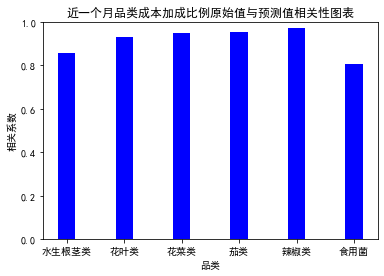

[0.8579935378664448, 0.9310360316221233, 0.9472598801731721, 0.9519101012873451, 0.9701126552472846, 0.8085022200630642]


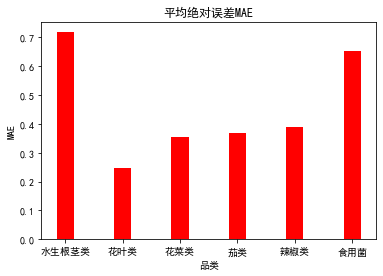

[0.7160858146293027, 0.24600384190700586, 0.35464928219864417, 0.3668183188173908, 0.38921413377681124, 0.6528170196200903]


In [22]:
cost_pre = np.array([])

j = 231
relate = []
cost = []

plt.figure(figsize=(15, 8))
for i in range(len(cost_addition.columns.tolist())):
    name = cost_addition.columns.tolist()[i]
    plt.subplot(j)
    plt.title(name)
    plt.ylabel('平均批发价')

    # 原始值与滤波值
    x = [*range(len(class_cost_in_daily[name]))]
    data = class_cost_in_daily[name].to_frame().fillna(class_cost_in_daily[name].mean())
   
    ts_diff = data.diff(1)
    ts_diff.dropna(inplace=True)

    ts_diff = ts_diff.diff(1)
    ts_diff.dropna(inplace=True)

    # 拟合ARIMA模型
    model = ARIMA(data, order=(1, 1, 1))
    results_ARIMA = model.fit()
    
    # 绘制拟合数据
    plt.scatter(x, data.values.reshape(1, -1).tolist()[0], s=1, label='原始值')
    plt.plot(results_ARIMA.fittedvalues.values, color='orange', label='基于模型拟合原始数据')
    plt.plot(results_ARIMA.predict(1085, 1092, dynamic=True), color='red', label='预测值')
    j+=1

    pred_y = results_ARIMA.fittedvalues.fillna(0).to_frame().values.reshape(1, -1).tolist()[0]
    data_list = data.values.reshape(1, -1).tolist()[0]

    v, p = spearmanr(data_list, pred_y)
    cost.append(CostFunc(pred_y, data_list))
    relate.append(v)
    cost_pre = np.append(cost_pre, results_ARIMA.predict(1086, 1092, dynamic=True).to_frame().values.tolist())
    
    
plt.legend(loc='best')    
plt.show()

plt.figure(figsize=(6, 4))
plt.ylim(0,1)
plt.bar(cost_addition.columns.tolist(), relate, lw=0.5,fc="blue",width=0.3)

plt.title("近一个月品类成本加成比例原始值与预测值相关性图表")
plt.xlabel('品类')
plt.ylabel('相关系数')
plt.show()

print(relate)

plt.figure(figsize=(6, 4))
plt.bar(cost_addition.columns.tolist(), cost, lw=0.5,fc="r",width=0.3)

plt.title("平均绝对误差MAE")
plt.xlabel('品类')
plt.ylabel('MAE')
plt.show()

print(cost)

In [23]:
cost_pre_df = pd.DataFrame(cost_pre.reshape(6, -1).T, columns = cost_addition.columns.to_list(), index=[*range(1, 8)])
cost_pre_df.style

,水生根茎类,花叶类,花菜类,茄类,辣椒类,食用菌
1,12.426304,3.249444,7.923586,4.667886,3.689850,3.744542
2,12.427823,3.249638,7.924180,4.666698,3.689799,3.718239
3,12.427928,3.249646,7.924310,4.666918,3.689802,3.712892
4,12.427935,3.249646,7.924339,4.666877,3.689802,3.711805
5,12.427935,3.249646,7.924346,4.666885,3.689802,3.711584
6,12.427935,3.249646,7.924347,4.666883,3.689802,3.711540
7,12.427935,3.249646,7.924347,4.666883,3.689802,3.711530


In [24]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

coef_:-3.325 intercept_:69.750
coef_:-13.275 intercept_:257.334
coef_:-2.682 intercept_:63.774
coef_:-1.016 intercept_:29.629
coef_:-2.528 intercept_:106.268
coef_:-5.180 intercept_:114.546


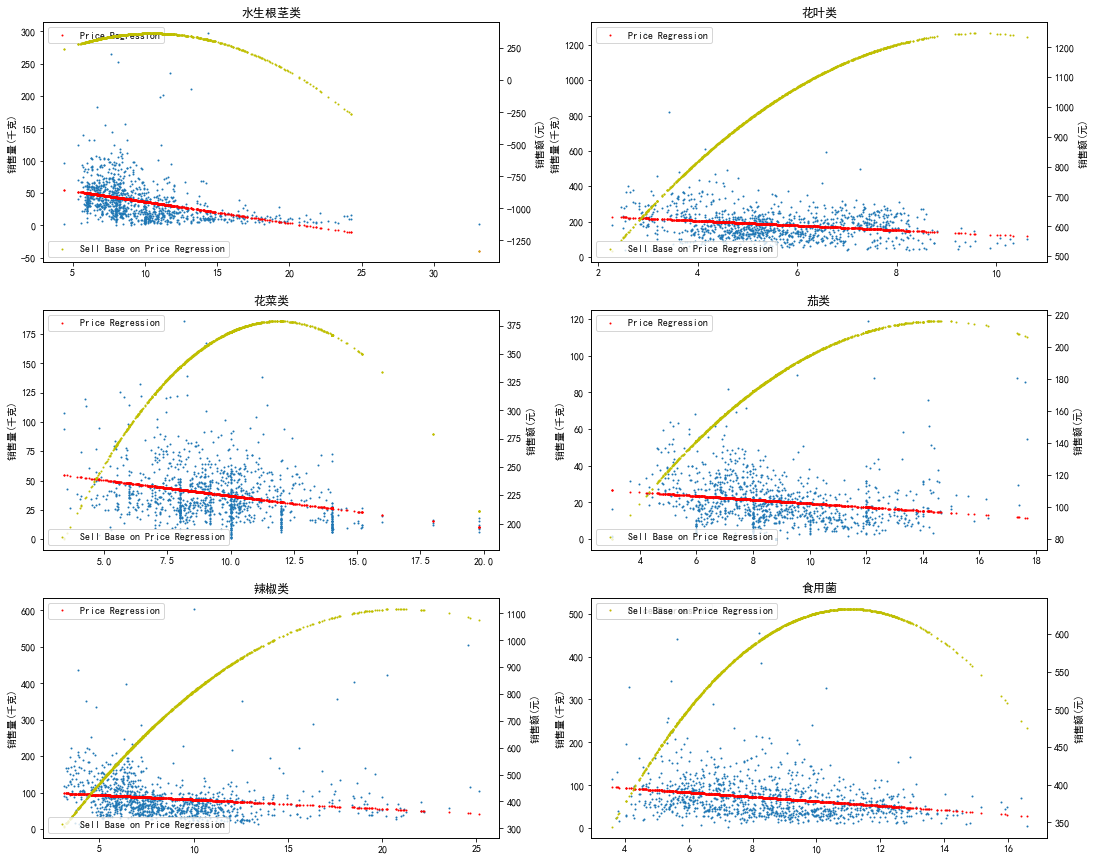

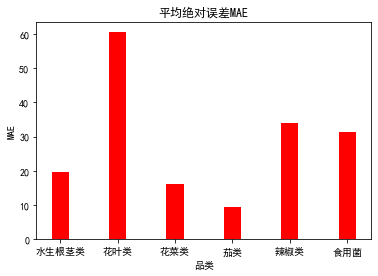

In [25]:
model = lm.LinearRegression()

cost = []
model_list = []

j = 321
plt.figure(figsize=(18, 15))
for i in range(len(cost_addition.columns.tolist())):
    name = cost_addition.columns.tolist()[i]
    ax1 = plt.subplot(j)
    plt.title(name)
    x = class_value_in_daily[name].fillna(class_value_in_daily[name].mean()).values
    y = class_sell_daily[name].fillna(class_sell_daily[name].mean()).values
    
    model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    pred_y = model.predict(x.reshape(-1, 1))
    ax1.set_ylabel('销售量(千克)')
    plt.scatter(x, y, s=1)
    plt.plot(x, pred_y, 'ro', label='Price Regression', markersize=1)
    plt.legend(loc=2)
    
    ax2 = ax1.twinx()
    plt.plot(x, pred_y.reshape(-1) * x.reshape(-1), 'yo', label='Sell Base on Price Regression', markersize=1)
    ax2.set_ylabel('销售额(元)') 
    plt.legend(loc=3)
    
    print('coef_:%.3f intercept_:%.3f' % (model.coef_, model.intercept_))
    model_list.append([model.coef_, model.intercept_])

    cost.append(CostFunc(pred_y, y).tolist()[0])
    j+=1

plt.legend(loc='best')
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(cost_addition.columns.tolist(), cost, lw=0.5,fc="r",width=0.3)

plt.title("平均绝对误差MAE")
plt.xlabel('品类')
plt.ylabel('MAE')
plt.show()

存在
当处于某种售价时的销售额关系式
$$
\begin{gather}
S=aP+b\\
P=C(1+\alpha)\\
\end{gather}
$$
且$a<0$
求利润$E$最大值
$$
\max(E)\iff\max(\alpha{S}=\alpha(a{C(1+\alpha)}+b))
$$

In [26]:
from scipy.optimize import fmin

def f(x, a, b, C):
    return x*(a*(C*(1+x))+b)

def fmax(func, x0, args=(), **kwargs):
    return fmin(lambda x: -func(x, *args), x0, **kwargs, disp=False)


add_list = []
for i in range(len(cost_addition.columns.to_list())):
    add_list.append([])
    for C in cost_pre_df[cost_addition.columns.to_list()[i]].tolist():
        # print('coef_:%.3f intercept_:%.3f cost:%.3f' % (model_list[i][0], model_list[i][1], C))
        result = fmax(f, 0.5, args=(model_list[i][0], model_list[i][1], C))
        add_list[i].append(result[0])
add_list

[[0.3439453124999999,
  0.3438476562499999,
  0.3438476562499999,
  0.3438476562499999,
  0.3438476562499999,
  0.3438476562499999,
  0.3438476562499999],
 [2.482812500000004,
  2.482714843750004,
  2.4826171875000043,
  2.4826171875000043,
  2.4826171875000043,
  2.4826171875000043,
  2.4826171875000043],
 [1.000292968750001,
  1.0001953125000012,
  1.0001953125000012,
  1.0000976562500012,
  1.0000976562500012,
  1.0000976562500012,
  1.0000976562500012],
 [2.624414062500004,
  2.6251953125000043,
  2.6250000000000044,
  2.6250976562500044,
  2.6250000000000044,
  2.6250976562500044,
  2.6250976562500044],
 [5.19658203125001,
  5.19658203125001,
  5.19658203125001,
  5.19658203125001,
  5.19658203125001,
  5.19658203125001,
  5.19658203125001],
 [2.4529296875000046,
  2.4738281250000043,
  2.478125000000004,
  2.479003906250004,
  2.4791992187500043,
  2.4791992187500043,
  2.4791992187500043]]